<a href="https://colab.research.google.com/github/EyberRosero/Analitica-De-Datos/blob/master/Punto_1_Red_Profunda_(Main_People).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construyendo un clasificador de imágenes con una Red Profunda

Se importan librerias **tensorflow** y **pandas** usadas en la construcción del clasificador 

In [30]:
import tensorflow as tf
import pandas as pd
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

Esta función sirve para graficar la Matriz de Confusion para comprobar la eficiencia del clasificador

In [31]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues): 
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax    

Comencemos cargando el conjunto de datos **Main People**. 


In [32]:
%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

print(lfw_people.images.shape)

(1288, 50, 37)


El conjunto de datos se debe dividir entre un **conjunto de entrenamiento** ``X_train_full`` y un **conjunto de prueba** ``X_test_full``, pero puede ser útil dividir aún más el conjunto de entrenamiento para tener un **conjunto de validación**:

In [175]:
X_train_full, X_test_full, y_train_full,y_test_full = train_test_split(lfw_people.images,lfw_people.target,test_size=0.15) 

In [176]:
X_train_full.shape

(1094, 50, 37)

In [177]:
X_test_full.shape

(194, 50, 37)

En este caso el **conjunto de entrenamiento** corresponde a un 85% del total del conjunto de datos, ahora dividamos este conjunto de entrenamiento completo en un **conjunto de validación** ``X_valid``y un **conjunto de entrenamiento** (más pequeño) ``X_train``. 

In [183]:
X_train, X_valid, y_train,y_valid = train_test_split(X_train_full,y_train_full,test_size=0.1)

In [184]:
X_train.shape

(984, 50, 37)

In [185]:
X_valid.shape

(110, 50, 37)

También **escalamos las intensidades de píxeles hasta el rango 0-1** y las convertimos en flotantes, dividiéndolas por 255.

In [186]:
X_train = X_train / 255.
X_valid = X_valid / 255.

Puede trazar una imagen usando la función *imshow()* de Matplotlib, con un mapa de color 'binario':

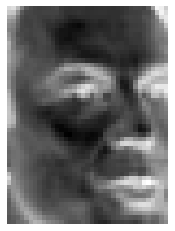

In [187]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Las etiquetas son los ID de clase (representados como *uint8*), de 0 a 6:

In [188]:
y_train

array([6, 3, 6, 2, 1, 3, 4, 1, 6, 1, 3, 0, 6, 4, 3, 3, 3, 1, 6, 1, 3, 0,
       1, 1, 3, 4, 2, 3, 4, 6, 2, 3, 3, 6, 0, 6, 3, 0, 6, 3, 3, 3, 6, 3,
       3, 6, 3, 4, 4, 3, 6, 0, 3, 1, 6, 3, 4, 3, 6, 0, 2, 3, 1, 0, 1, 6,
       3, 3, 4, 3, 3, 1, 3, 5, 6, 3, 3, 4, 2, 4, 1, 6, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 6, 1, 6, 6, 3, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 4,
       5, 4, 0, 1, 6, 3, 1, 6, 3, 3, 2, 2, 5, 2, 3, 0, 6, 3, 3, 4, 3, 1,
       4, 6, 3, 0, 3, 3, 3, 3, 1, 2, 0, 6, 4, 6, 0, 3, 3, 3, 1, 3, 1, 6,
       3, 4, 3, 3, 1, 4, 1, 1, 6, 2, 3, 3, 4, 3, 6, 1, 1, 3, 3, 1, 2, 3,
       1, 3, 3, 0, 3, 4, 3, 6, 3, 4, 5, 1, 0, 3, 4, 6, 3, 1, 3, 5, 3, 0,
       5, 6, 3, 0, 4, 3, 2, 1, 3, 3, 3, 4, 1, 3, 3, 3, 6, 4, 3, 3, 3, 5,
       6, 3, 1, 3, 3, 3, 3, 3, 6, 2, 1, 3, 6, 6, 1, 4, 1, 1, 2, 1, 4, 0,
       1, 1, 6, 2, 3, 5, 1, 2, 1, 3, 4, 3, 5, 4, 3, 1, 3, 5, 5, 4, 3, 3,
       2, 3, 1, 3, 6, 3, 3, 2, 4, 3, 0, 2, 3, 3, 3, 3, 0, 1, 3, 3, 3, 6,
       3, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 2,

Aquí están los nombres de clase correspondientes:

In [189]:
class_names = lfw_people.target_names
class_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

Echemos un vistazo a una muestra de las imágenes en el conjunto de datos:

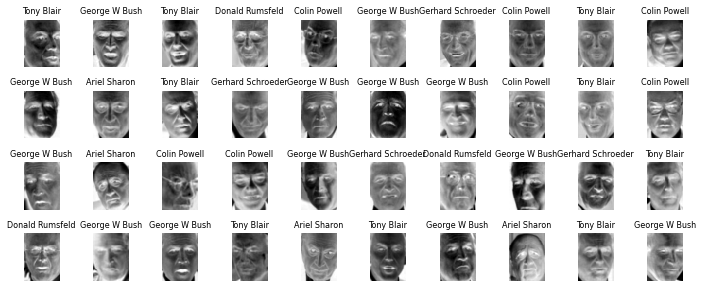

In [190]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=8)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

###Se crea el modelo con arquitectura funcional:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1850)              0         
_________________________________________________________________
h1 (Dense)                   (None, 100)               185100    
_________________________________________________________________
h2 (Dense)                   (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 7)                 357       
Total params: 190,507
Trainable params: 190,507
Non-trainable params: 0
_________________________________________________________________


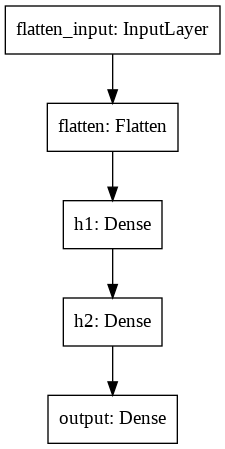

In [241]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
'''
# ARQUITECTURA secuencial 
#Se contruye la entrada de la red, que recibe los datos de entrenamiento con el tamaño
#de las imagenes (50,37)

#Primera CAPA
#construimos la primera capa y la agregamos al modelo. Es una capa Flatten cuyo papel es 
#simplemente convertir cada imagen de entrada en una matriz 1D. Alternativamente, puede 
#agregar un keras.layers.InputLayer como la primera capa, estableciendo $shape = [50,37]$.

#A continuación, agregamos una capa oculta densa con 100 neuronas. Utilizará la función 
#de activación tanh. Cada capa densa gestiona su propia matriz de peso, que contiene todos 
#los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de 
#términos de sesgo (uno por neurona).

#A continuación, agregamos una capa oculta densa con 50 neuronas. Utilizará la función 
#de activación tanh. Cada capa densa gestiona su propia matriz de peso, que contiene todos 
#los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de 
#términos de sesgo (uno por neurona).

#Finalmente, agregamos una capa de salida densa con 7 neuronas (una por clase), usando 
#la función de activación softmax (porque las clases son exclusivas).
'''
#arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.Dense(100,activation="tanh", name='h1'),
    tf.keras.layers.Dense(50, activation="tanh",name='h2'),
    tf.keras.layers.Dense(7,activation='softmax',name='output')
])


#model_fun = tf.keras.Model(inputs=input_l,outputs=output)
model.summary()
tf.keras.utils.plot_model(model)

### Compilando el modelo
Después de crear un modelo, debe llamar a su método ``compile()`` para especificar la función de pérdida y el optimizador a utilizar. Opcionalmente, también puede especificar una lista de métricas adicionales (``learning_rate=0.0001``) para calcular durante el entrenamiento y la evaluación:

In [242]:
model.compile(loss="sparse_categorical_crossentropy", #derivar por dentro
              loss_weights = 0.15,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]) #monitorear medida de desempeño (solo para ver)

## Entrenando y evaluando el modelo
Ahora el modelo está listo para ser entrenado. Para esto, simplemente necesitamos llamar a su método ``fit()``. 
- Le pasamos las características de entrada ``X_train`` y las clases de destino ``y_train``, así como la cantidad de épocas para entrenar (o de lo contrario, sería predeterminado a solo 1, lo que definitivamente no sería suficiente para converger en una buena solución). 
- También pasamos un conjunto de validación (esto es opcional): Keras medirá la pérdida y las métricas adicionales en este conjunto al final de cada época, lo cual es muy útil para ver qué tan bien se desempeña realmente el modelo.
- **NOTA:** si el rendimiento en el entrenamiento es mucho mejor que en el conjunto de validación, su modelo probablemente esté sobreajustando el conjunto de entrenamiento (o hay un error, como una falta de coincidencia de datos entre el conjunto de entrenamiento y el conjunto de validación):

In [243]:
history = model.fit(X_train, y_train, epochs=250,batch_size=64,
                    validation_data=(X_valid, y_valid))

Epoch 1/250
16/16 [==============================] - 0s 11ms/step - loss: 0.2716 - accuracy: 0.3567 - val_loss: 0.2758 - val_accuracy: 0.3818
Epoch 2/250
16/16 [==============================] - 0s 5ms/step - loss: 0.2530 - accuracy: 0.4075 - val_loss: 0.2605 - val_accuracy: 0.3909
Epoch 3/250
16/16 [==============================] - 0s 6ms/step - loss: 0.2469 - accuracy: 0.4136 - val_loss: 0.2568 - val_accuracy: 0.3909
Epoch 4/250
16/16 [==============================] - 0s 5ms/step - loss: 0.2421 - accuracy: 0.4146 - val_loss: 0.2569 - val_accuracy: 0.3909
Epoch 5/250
16/16 [==============================] - 0s 5ms/step - loss: 0.2381 - accuracy: 0.4390 - val_loss: 0.2506 - val_accuracy: 0.4273
Epoch 6/250
16/16 [==============================] - 0s 27ms/step - loss: 0.2315 - accuracy: 0.4461 - val_loss: 0.2495 - val_accuracy: 0.4091
Epoch 7/250
16/16 [==============================] - 0s 5ms/step - loss: 0.2271 - accuracy: 0.4756 - val_loss: 0.2434 - val_accuracy: 0.4273
Epoch 8/250

Puede ver que la **pérdida de entrenamiento se redujo**, lo cual es una buena señal, y la precisión de validación alcanzó el $89\%$ (``val_accuracy: 0.8909``)después de 300 épocas, no muy lejos de la precisión del entrenamiento (``accuracy: 0.9989``), por lo que no parece haber demasiado ajuste.

El método ``fit()`` devuelve un objeto **history** que contiene: 
1. los parámetros de entrenamiento (``history.params``), 
2. la lista de épocas por las que pasó (``history.epoch``) y, 
3. lo más importante, un diccionario (``history.history``) que contiene la pérdida y las métricas adicionales que midió al final de cada época en el conjunto de entrenamiento y en el conjunto de validación (si corresponde). 

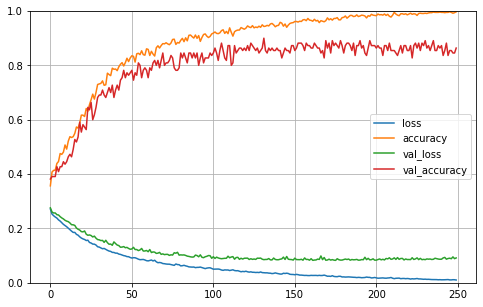

In [244]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

Una vez que esté **satisfecho con la precisión de validación de su modelo**, debe evaluarla en el *conjunto de prueba* (``X_test_full``) para estimar el error de generalización antes de implementar el modelo en producción:

In [245]:
model.evaluate(X_test_full, y_test_full)

7/7 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.8351


[0.12300552427768707, 0.8350515365600586]

(194, 7)
              precision    recall  f1-score   support

           0       0.45      0.83      0.59         6
           1       0.89      0.89      0.89        38
           2       0.73      0.69      0.71        16
           3       0.96      0.84      0.90        88
           4       0.72      0.87      0.79        15
           5       1.00      0.58      0.74        12
           6       0.64      0.95      0.77        19

    accuracy                           0.84       194
   macro avg       0.77      0.81      0.77       194
weighted avg       0.87      0.84      0.84       194



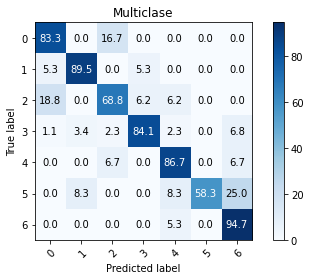

In [246]:
#conjunto de test 
ytest_e = model.predict(X_test_full)
print(ytest_e.shape)
plot_confusion_matrix(y_test_full, ytest_e.argmax(axis=1),classes=np.unique(y_test_full))
plt.title('Multiclase')
print(classification_report(y_test_full, ytest_e.argmax(axis=1)))

- Como vimos anteriormente, es **común obtener un rendimiento ligeramente inferior en el conjunto de prueba** que en el conjunto de validación, porque los hiperparámetros están sintonizados en el conjunto de validación, no en el conjunto de prueba (*sin embargo, en este ejemplo, no lo hicimos cualquier ajuste de hiperparámetro, por lo que la precisión más baja es solo mala suerte*).

###Usando el modelo para hacer predicciones

A continuación, podemos usar el metodo ``predict()`` del modelo para hacer predicciones sobre nuevas instancias. Como no tenemos instancias nuevas reales, solo usaremos las primeras 3 instancias del **conjunto de prueba**    (``X_test_full``)

In [247]:
X_new = X_test_full[:3]
y_new = y_test_full[:3]
y_new


array([3, 3, 6])

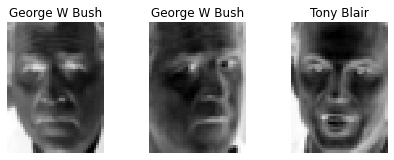

In [248]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test_full[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

In [249]:
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.06, 0.  , 0.  , 0.93, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]], dtype=float32)

In [250]:
y_pred = model.predict_classes(X_new)
y_pred

array([3, 3, 6])

In [251]:
np.array(class_names)[y_pred]

array(['George W Bush', 'George W Bush', 'Tony Blair'], dtype='<U17')